In [33]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, auc, f1_score, r2_score, mean_squared_error, precision_recall_curve, average_precision_score
from sklearn.linear_model import ElasticNet, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [34]:
#Open Data and read data 
heart_data = pd.read_csv("heart_disease_uci(1).csv")

#Examine Data structure 
print(heart_data.info())
print(heart_data.head())
# print(heart_data.describe())
# print(heart_data.isnull().sum())
# print(heart_data['slope'].value_counts())
print(heart_data['num'].value_counts())

def dropMissing(data: pd.DataFrame, threshold = 0.15):
    missing = data.isna().sum() / data.shape[0] > threshold
    toDrop = missing[missing].index
    print(f"Dropping {toDrop}")
    data.drop(columns=toDrop, inplace=True)

def fillMissing(data: pd.DataFrame):
    missing = data.isna().sum() > 0
    for colName in missing[missing].index:
        if data[colName].dtype == 'object':
            data[colName] = data[colName].fillna("Unknown")
        else:
            data[colName] = data[colName].fillna(data[colName].median())

#create cholestrol dataset for linear regression
chol_data = heart_data.copy() #chol model dataset
chol_data['chol'].dropna() # drop blank target rows
# chol feature engineering
dropMissing(chol_data, .50)
fillMissing(chol_data)
chol_data = pd.get_dummies(chol_data, drop_first=True) #one hot encode categorical/object features
chol_data.info()

#create heart disease model for logistic regression
disease_data = heart_data.copy()
disease_data['num'] = disease_data['num'] > 0 # categorical to binary for target column
dropMissing(disease_data, .50)
fillMissing(disease_data)
disease_data = pd.get_dummies(disease_data, drop_first=True) #one hot encode categorical/object features



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       920 non-null    int64  
 1   sex       920 non-null    object 
 2   dataset   920 non-null    object 
 3   cp        920 non-null    object 
 4   trestbps  861 non-null    float64
 5   chol      890 non-null    float64
 6   fbs       830 non-null    object 
 7   restecg   918 non-null    object 
 8   thalch    865 non-null    float64
 9   exang     865 non-null    object 
 10  oldpeak   858 non-null    float64
 11  slope     611 non-null    object 
 12  ca        309 non-null    float64
 13  thal      434 non-null    object 
 14  num       920 non-null    int64  
dtypes: float64(5), int64(2), object(8)
memory usage: 107.9+ KB
None
   age     sex    dataset               cp  trestbps   chol    fbs  \
0   63    Male  Cleveland   typical angina     145.0  233.0   True   
1   67    Male  Clevela

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.496e+06, tolerance: 7.813e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordi

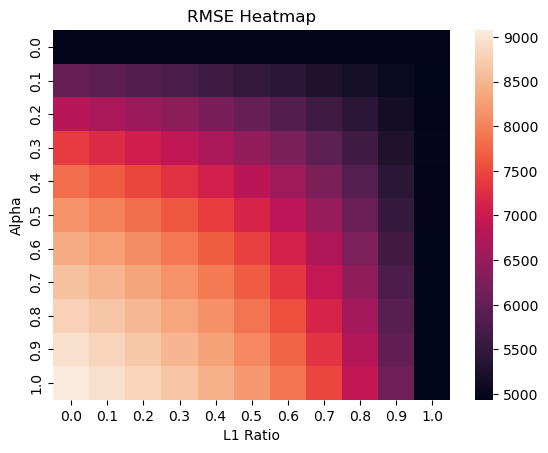

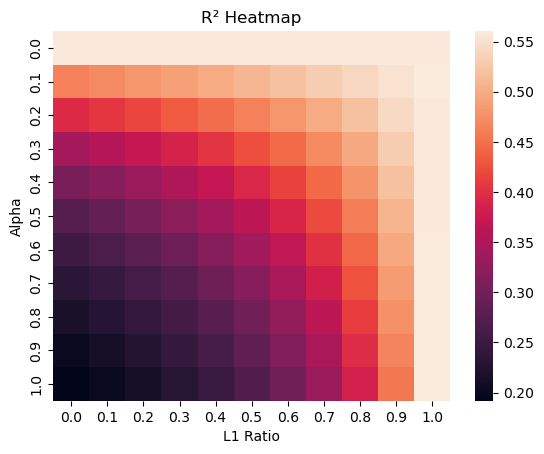

Best RMSE: 4937.0568 at Alpha=1.0, L1 Ratio=1.0
Best r2: 0.1918 at Alpha=1.0, L1 Ratio=0.0


In [35]:

#Regression Models
#For regression: Predict Cholestrol levels (column name = chol)

# Regression target: 'chol'
X = chol_data.drop(columns=['chol', 'num'])  # Drop targets from features 
y = chol_data['chol']  # Cholesterol level as target for regression

#  Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Hyperparameter grid 
mseArray = np.zeros([11, 11])
r2Array = np.zeros([11, 11])
best_rmse, best_r2 = float('inf'), float('inf')
alphas = np.arange(0, 1.1, 0.1)
l1_ratio = np.arange(0, 1.1, 0.1)
best_rmse_config = [None, None]
best_r2_config = [None, None]

for i, myAlpha in enumerate(alphas):
    for j, myL1 in enumerate(l1_ratio):
        # Train ElasticNet model
        model = ElasticNet(alpha=myAlpha, l1_ratio=myL1)  
        model.fit(X_train, y_train) #fit data to training data 

        # Predict and evaluate
        y_pred =  model.predict(X_test)

        # Evaluate the model
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        # print(f"Mean Squared Error: {mse}")
        # print(f"R^2 Score: {r2}")
        if mse < best_rmse:
            best_rmse = mse
            best_rmse_config = [str(myAlpha), str(myL1)]
        if r2 < best_r2:
            best_r2 = r2
            best_r2_config = [str(myAlpha), str(myL1)]
        mseArray[i][j] = mse
        r2Array[i][j] = r2

sns.heatmap(mseArray, xticklabels=np.round(l1_ratio, 1), yticklabels=np.round(alphas, 2))
plt.title("RMSE Heatmap")
plt.xlabel("L1 Ratio")
plt.ylabel("Alpha")
plt.show()

sns.heatmap(r2Array, xticklabels=np.round(l1_ratio, 2), yticklabels=np.round(alphas, 2))
plt.title("R² Heatmap")
plt.xlabel("L1 Ratio")
plt.ylabel("Alpha")
plt.show()

print(f"Best RMSE: {best_rmse:.4f} at Alpha={best_rmse_config[0]}, L1 Ratio={best_rmse_config[1]}")
print(f"Best r2: {best_r2:.4f} at Alpha={best_r2_config[0]}, L1 Ratio={best_r2_config[1]}")

Log-Reg - Accuracy: 0.82, Precision: 0.84, Recall: 0.83, F1 Score: 0.83
k-NN - Accuracy: 0.85, Precision: 0.86, Recall: 0.88, F1 Score: 0.87
Best parameters for k-NN: {'metric': 'manhattan', 'n_neighbors': 10}
Best score for k-NN: 0.7935198643410853


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


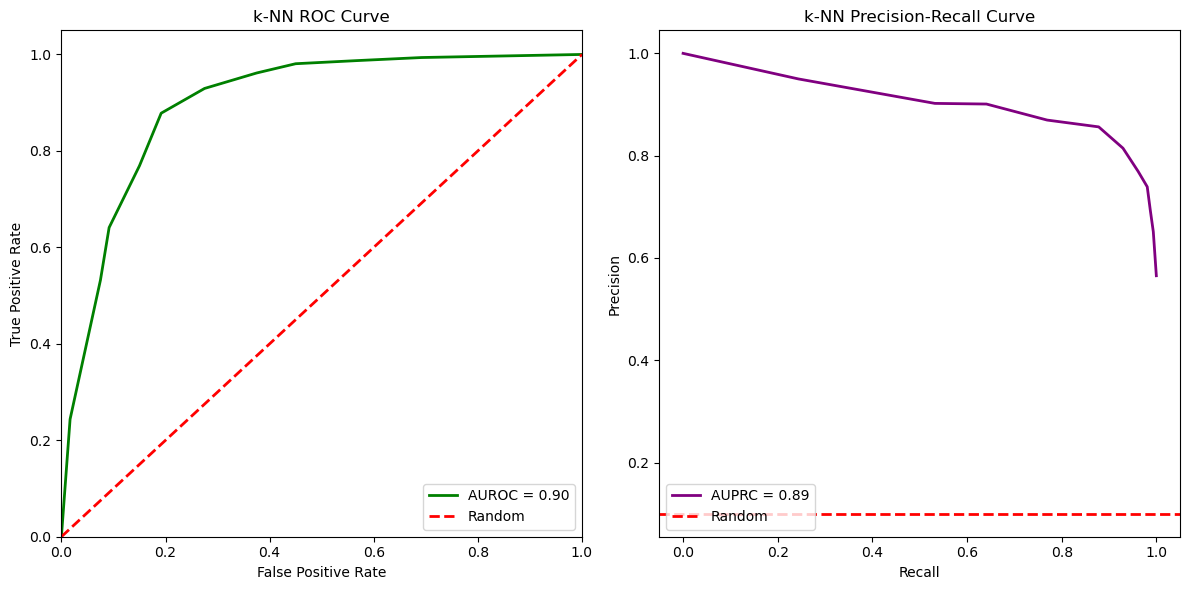

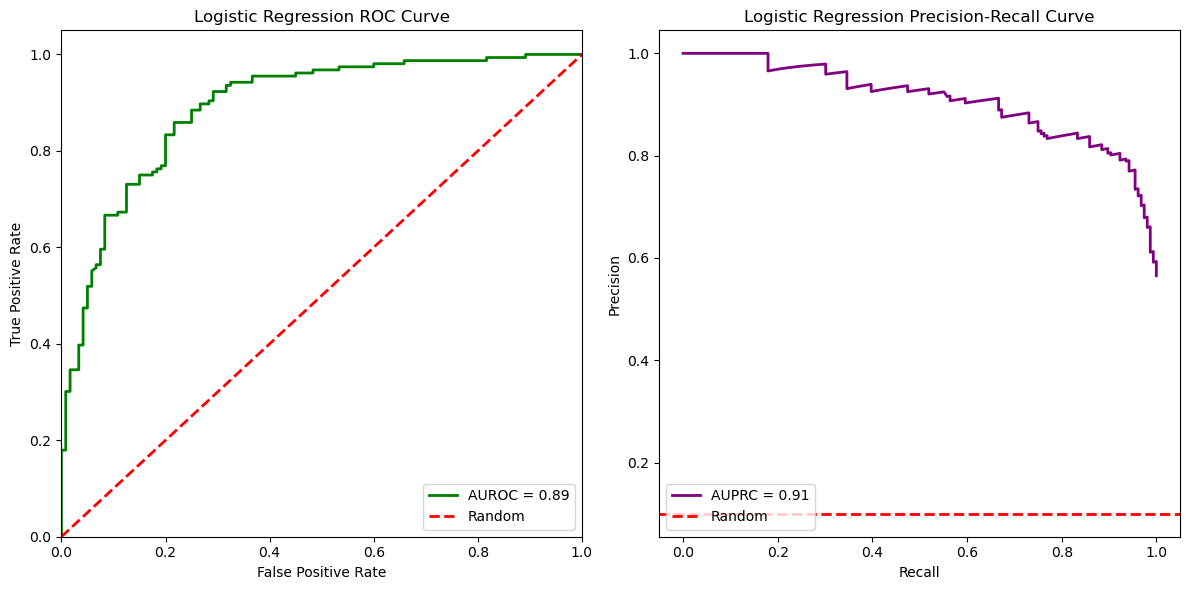

In [ ]:
#Classification Models 
def plot_curves(tpr,fpr,auroc,precision,recall,auprc,model_name,minority_class=0.1):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot ROC curve
    ax1.plot(fpr, tpr, color='green', lw=2, label='AUROC = %0.2f' % auroc)
    ax1.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('{} ROC Curve'.format(model_name))
    ax1.legend(loc='lower right')

    # Plot Precision-Recall curve
    ax2.plot(recall, precision, color='purple', lw=2, label='AUPRC = %0.2f' % auprc)
    ax2.axhline(y=minority_class, color='red', lw=2, linestyle='--', label='Random')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('{} Precision-Recall Curve'.format(model_name))
    ax2.legend(loc='lower left')

    plt.tight_layout()
    plt.show()

#For classification: predict presence of heart disease as bonary classification task (column name = num)
#Classifcation target: 'num'
X = disease_data.drop(columns=['chol', 'num'])  # Drop targets from features 
y = disease_data['num']  # Cholesterol level as target for regression

#  Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)

#Logistic Regression 
param_grid_log_reg = {'solver': ['liblinear', 'saga'],'penalty': ['l1', 'l2']}
grid_search_log_reg = GridSearchCV(LogisticRegression(random_state=42, max_iter=100, C=1.0), param_grid_log_reg, cv=5, scoring='accuracy')
grid_search_log_reg.fit(X_train, y_train)
#Evaluate Logisitc Regression 
y_scores = grid_search_log_reg.predict_proba(X_test)[:, 1]


# Train a k-NN classifier
param_grid_knn = {'n_neighbors': [1,5,10],'metric': ['euclidean', 'manhattan']}
grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='accuracy')
# knn = KNeighborsClassifier(n_neighbors=7,metric='manhattan')
grid_search_knn.fit(X_train, y_train)

# Predict probabilities
y_scores_knn = grid_search_knn.predict_proba(X_test)[:, 1]

# Evaluate the Logisitic Regression and k-NN models
models = {'Log-Reg': grid_search_log_reg, 'k-NN': grid_search_knn}
for name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"{name} - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")


# Compute ROC curve and ROC area
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_scores_knn)

# Print best parameters and scores
print(f"Best parameters for k-NN: {grid_search_knn.best_params_}")
print(f"Best score for k-NN: {grid_search_knn.best_score_}")

auroc_knn = roc_auc_score(y_test, y_scores_knn)
auprc_knn = average_precision_score(y_test, y_scores_knn)

# For k-NN
precision_knn, recall_knn, _ = precision_recall_curve(y_test, y_scores_knn)
plot_curves(tpr_knn, fpr_knn, auroc_knn, precision_knn, recall_knn, auprc_knn, model_name='k-NN')

y_scores_log = grid_search_log_reg.predict_proba(X_test)[:, 1]
fpr_log, tpr_log, _ = roc_curve(y_test, y_scores_log)
precision_log, recall_log, _ = precision_recall_curve(y_test, y_scores_log)
auroc_log = roc_auc_score(y_test, y_scores_log)
auprc_log = average_precision_score(y_test, y_scores_log)

plot_curves( tpr_log, fpr_log, auroc_log, precision_log, recall_log, auprc_log, model_name='Logistic Regression')